## This is a simple script to demonstrate we can load and calculate fastcat correlation function using treecorr

You need to have treecorr python module (hint: pip install treecorr).

You also need to have fastcat in your python path and have COLORE_MOCKS environment variable set to 
where your mocks reside.

In [1]:
%pylab inline
import numpy as np
import fastcat as fc
import treecorr as tc
import healpy as hp
import os
try:
    path=os.environ['FASTCAT_MOCKS']
except KeyError:
    path="./"

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
data=fc.Catalog(read_from=path+"/catalog0.h5")

updating to version  0.2


In [3]:
# Let's see what are types of our window func and photoz objects
print "Window obj:",data.window.typestr,type(data.window)
print "PhotoZ obj:",data.photoz.typestr,type(data.photoz)

Window obj: decbcut <class 'fastcat.window.WindowDecBcut'>
PhotoZ obj: gauss <class 'fastcat.photoz.PhotoZGauss'>


In [4]:
# Let's look at some of the photo-z interfaces
# PhotoZ object
pz=data.photoz
# first let's take just first five galaxies
arr5=data[[np.random.uniform(len(data[:])) for i in range(5)]]

In [5]:
# Mean and RMS
pz.getMeanRMS(arr5)

(array([ 0.78878874,  0.95371532,  0.69372851,  0.89674741,  0.9267087 ], dtype=float32),
 array([ 0.01788789,  0.01953715,  0.01693728,  0.01896747,  0.01926709], dtype=float32))

In [6]:
# get mins and maxes
pz.getMinMax(arr5)

(array([ 0.69934928,  0.85602957,  0.60904211,  0.80191004,  0.83037329], dtype=float32),
 array([ 0.87822819,  1.05140114,  0.77841491,  0.99158478,  1.02304411], dtype=float32))

In [7]:
# get probabilities at z=1.0 +- (0.01)
pz.PofZ(arr5,1.0,0.01)

array([  0.00000000e+00,   4.55161899e-06,   0.00000000e+00,
         1.48806185e-24,   4.48518745e-13], dtype=float32)

In [8]:
# Let's take a slice between zmin and zmax
zcent=0.4
zbinsize=0.1
cutdata=data[np.where(abs(data['z']-zcent)<zbinsize/2)]
print "Picked",len(cutdata),"from",len(data.data),"objects."

Picked 2739670 from 48650776 objects.


In [9]:
## now we need a random catalog with the same z distribution. Start by making a 10x
## biger fullsky random catalog
Nboost=10
ran=np.hstack((cutdata,)*10)
Nr=len(ran)
# randomize ras and decs
ran['ra']=np.random.uniform(0,360,Nr)
ran['dec']=np.degrees(np.arcsin(np.random.uniform(-1,1,Nr)))

In [10]:
## now we need to cut to our survey area
ran=data.window.applyWindow(ran)

After window:  27396700 -> 13909107


In [11]:
## courtsy of fhaviersanchez
def make_hp_map(nside,data):
    import healpy as hp
    pix_nums = hp.ang2pix(nside,np.pi/2-data['dec']*np.pi/180,data['ra']*np.pi/180)
    bin_count = np.bincount(pix_nums)
    map_gal = np.append(bin_count,np.zeros(12*nside**2-len(bin_count)))
    return map_gal

/home/anze/local/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


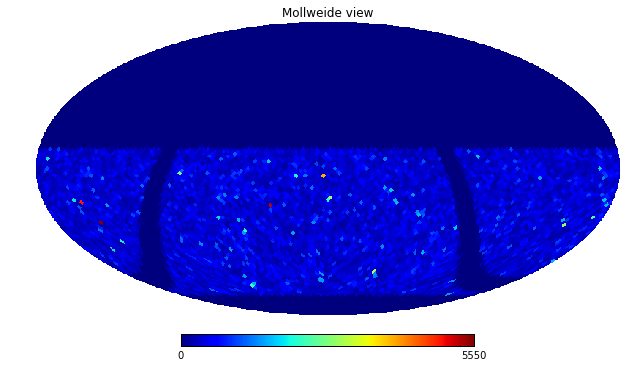

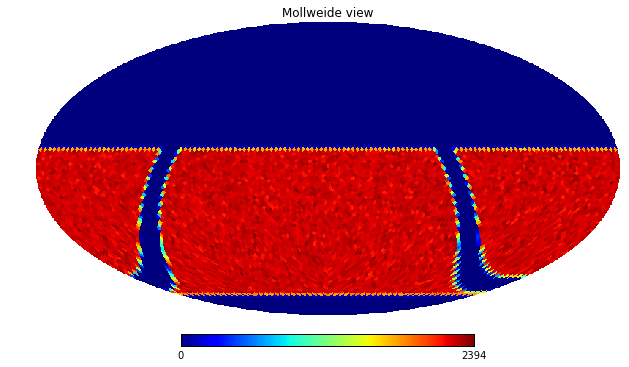

In [12]:
## plot two catalogs
hp.mollview(make_hp_map(32,cutdata))
hp.mollview(make_hp_map(32,ran))

In [13]:
#treecorr catalogs
cat=tc.Catalog(ra=cutdata['ra'],dec=cutdata['dec'],ra_units='degrees',dec_units='degrees')
rcat=tc.Catalog(ra=ran['ra'],dec=ran['dec'],ra_units='degrees',dec_units='degrees')

In [14]:
## correlators
dd=tc.NNCorrelation(min_sep=0.001,bin_size=0.1,max_sep=40., sep_units='degrees')
dd.process(cat)
dr=tc.NNCorrelation(min_sep=0.001,bin_size=0.1,max_sep=40., sep_units='degrees')
dr.process(cat,rcat)
rr=tc.NNCorrelation(min_sep=0.001,bin_size=0.1,max_sep=40., sep_units='degrees')
rr.process(rcat,rcat)

In [15]:
#print logr,meanlogr
xi,xivar=dd.calculateXi(rr,dr)
logr,meanlogr=dd.logr, dd.meanlogr
rr=exp(logr)

[]

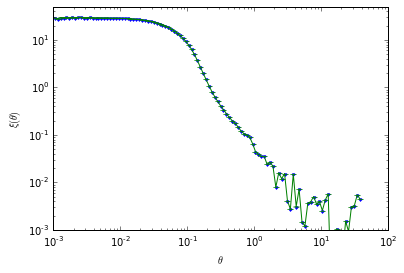

In [16]:
pylab.plot(rr,abs(xi),'.')
pylab.errorbar(rr,abs(xi),yerr=sqrt(xivar))
pylab.xlabel('$\\theta$')
pylab.ylabel('$\\xi(\\theta)$')
pylab.ylim(1e-3,50)
pylab.loglog()